### Importing Packages

In [113]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.metrics import classification_report, confusion_matrix, jaccard_similarity_score, f1_score, log_loss

%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

### Load Data From CSV File  

In [3]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
# !conda install -c anaconda seaborn -y

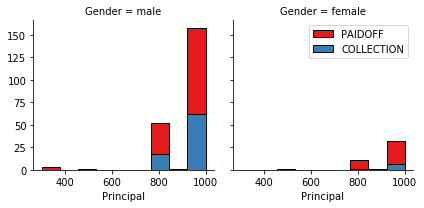

In [8]:
bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

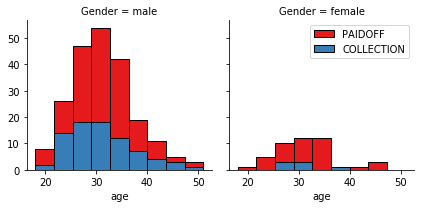

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

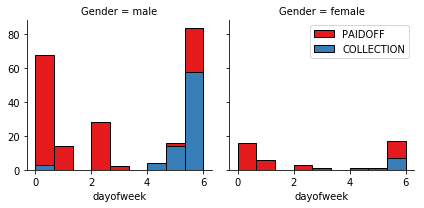

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


###  Using One hot encoding to convert loan_status to numeric

In [17]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [18]:
df['loan_status'] = pd.get_dummies(df['loan_status'])

In [19]:
df['loan_status'].value_counts()

0    260
1     86
Name: loan_status, dtype: int64

In [20]:
df.rename(columns = {'loan_status':'defaulted'}, inplace = True)

In [21]:
df.defaulted.value_counts()

0    260
1     86
Name: defaulted, dtype: int64

### Feature selection

Lets defind feature sets, X:

In [22]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [23]:
y = df['defaulted'].values
y[0:5]

array([0, 0, 0, 0, 0], dtype=uint8)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [24]:
X

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1
5,1000,30,36,0,1,0,0,1
6,1000,30,28,0,1,0,0,1
7,800,15,26,0,1,0,0,1
8,300,7,29,0,1,0,0,1
9,1000,15,39,0,1,0,1,0


In [26]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

# Train Test Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.25, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (259, 8) (259,)
Test set: (87, 8) (87,)


# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [28]:
k = 3
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [29]:
yhat = neigh.predict(X_test)

In [30]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8146718146718147
Test set Accuracy:  0.7701149425287356


In [31]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.72413793, 0.75862069, 0.77011494, 0.77011494, 0.70114943,
       0.75862069, 0.75862069, 0.77011494, 0.75862069, 0.75862069,
       0.71264368, 0.73563218, 0.73563218, 0.72413793])

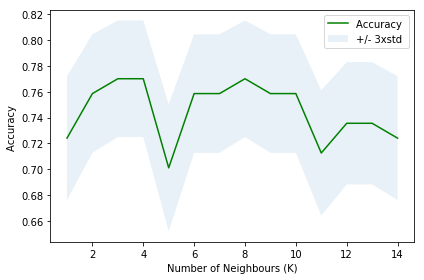

In [32]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbours (K)')
plt.tight_layout()
plt.show()

In [33]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7701149425287356 with k= 3


# Decision Tree

In [79]:
d_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 12, min_samples_split=4, random_state = 42)
d_tree.fit(X_train,y_train)
d_tree

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=12,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [80]:
yhat = d_tree.predict(X_test)

In [81]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, d_tree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.8648648648648649
Test set Accuracy:  0.7471264367816092


In [82]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85        69
           1       0.36      0.28      0.31        18

   micro avg       0.75      0.75      0.75        87
   macro avg       0.59      0.57      0.58        87
weighted avg       0.73      0.75      0.73        87



In [83]:
d_tree.feature_importances_

array([0.01199248, 0.11691385, 0.32559302, 0.04506499, 0.39344383,
       0.00951637, 0.03252094, 0.06495453])

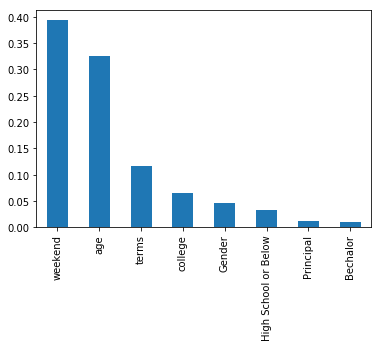

In [84]:
pd.Series(data=d_tree.feature_importances_,index=Feature.columns).sort_values(ascending=False).plot(kind='bar');

# Support Vector Machine

In [85]:
model = svm.SVC(C = 0.1, kernel='rbf', gamma='scale', max_iter = -1, random_state=42)
model.fit(X_train, y_train) 

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)

In [86]:
yhat = model.predict(X_test)

In [87]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.79      1.00      0.88        69
           1       0.00      0.00      0.00        18

   micro avg       0.79      0.79      0.79        87
   macro avg       0.40      0.50      0.44        87
weighted avg       0.63      0.79      0.70        87

Confusion matrix, without normalization
[[ 0 18]
 [ 0 69]]


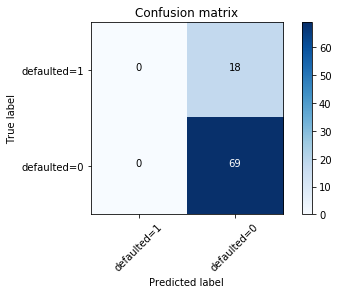

In [88]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['defaulted=1','defaulted=0'],normalize= False,  title='Confusion matrix')

In [89]:
jaccard_similarity_score(y_test, yhat)

0.7931034482758621

# Logistic Regression

In [90]:
LR = LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=42).fit(X_train,y_train)
yhat = LR.predict(X_test)
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5, 0.5],
       [0.5,

In [91]:
jaccard_similarity_score(y_test, yhat)

0.7931034482758621

In [92]:
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[ 0 18]
 [ 0 69]]


Confusion matrix, without normalization
[[ 0 18]
 [ 0 69]]


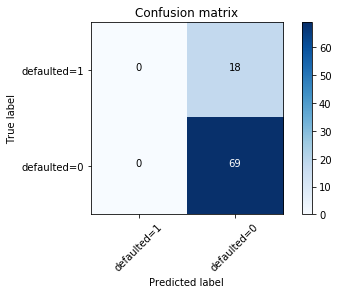

In [93]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['defaulted=1','defaulted=0'],normalize= False,  title='Confusion matrix')

In [94]:
print (classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.79      1.00      0.88        69
           1       0.00      0.00      0.00        18

   micro avg       0.79      0.79      0.79        87
   macro avg       0.40      0.50      0.44        87
weighted avg       0.63      0.79      0.70        87



/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [95]:
log_loss(y_test, yhat_prob)

0.6931471805599455

# Model Evaluation using Test set

In [96]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

First, download and load the test set:

In [97]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2020-07-20 03:06:48--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

100%[======================================>] 3,642       --.-K/s   in 0s      

2020-07-20 03:06:48 (277 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [98]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [99]:
test_df.shape

(54, 10)

In [100]:
test_df.loan_status.value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [101]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]
Y = test_df['loan_status'].values
Y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [106]:
#test the KNN algorithm already trained with K=3
yhatKNN=neigh.predict(X)
KNNJaccard = jaccard_similarity_score(y, yhatKNN)
KNNF1 = f1_score(y, yhatKNN, average='weighted')
print("KNN F1-score: %.2f" % KNNF1 )
print("KNN Jaccard Score: %.2f" % KNNJaccard)

yhatDEC = d_tree.predict(X)
DTJaccard = jaccard_similarity_score(y, yhatDEC)
DTF1 = f1_score(y, yhatDEC, average='weighted')
print("Decision Tree F1-score: %.2f" % DTF1 )
print("Decision Tree Jaccard Score: %.2f" % DTJaccard)

yhatSVM=model.predict(X)
SVMJaccard = jaccard_similarity_score(y, yhatSVM)
SVMF1 = f1_score(y, yhatSVM, average='weighted')
print("SVM F1-score: %.2f" % SVMF1)
print("SVM Jaccard score: %.2f" % SVMJaccard)

yhatLOG = LR.predict(X)
yhatLOGproba = LR.predict_proba(X)
LogRJaccard = jaccard_similarity_score(y, yhatLOG)
LogRF1 = f1_score(y, yhatLOG, average='weighted')
Logloss = log_loss(y, yhatLOGproba)
print("LogLoss: : %.2f" % Logloss)
print("LOG F1-score: %.4f" % LogRF1)
print("LOG Jaccard score: %.4f" % LogRJaccard)

KNN F1-score: 0.71
KNN Jaccard Score: 0.76
Decision Tree F1-score: 0.82
Decision Tree Jaccard Score: 0.84
SVM F1-score: 0.64
SVM Jaccard score: 0.75
LogLoss: : 0.69
LOG F1-score: 0.6448
LOG Jaccard score: 0.7514


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [107]:
d = {'Algorithm': ['KNN','Decision Tree', 'SVM','LogisticRegression'], 'Jaccard': [KNNJaccard, DTJaccard,SVMJaccard, LogRJaccard], 'F1-score':[KNNF1, DTF1,SVMF1, LogRF1], 'LogLoss':[None, None, None, Logloss]}
report_df = pd.DataFrame(data=d)

In [108]:
report_df

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.757225,0.713095,NaN
1,Decision Tree,0.835260,0.823988,NaN
2,SVM,0.751445,0.644804,NaN
3,LogisticRegression,0.751445,0.644804,0.693147


In [109]:
report_df.set_index('Algorithm', inplace = True)

In [110]:
report_df

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.757225,0.713095,NaN
Decision Tree,0.835260,0.823988,NaN
SVM,0.751445,0.644804,NaN
LogisticRegression,0.751445,0.644804,0.693147


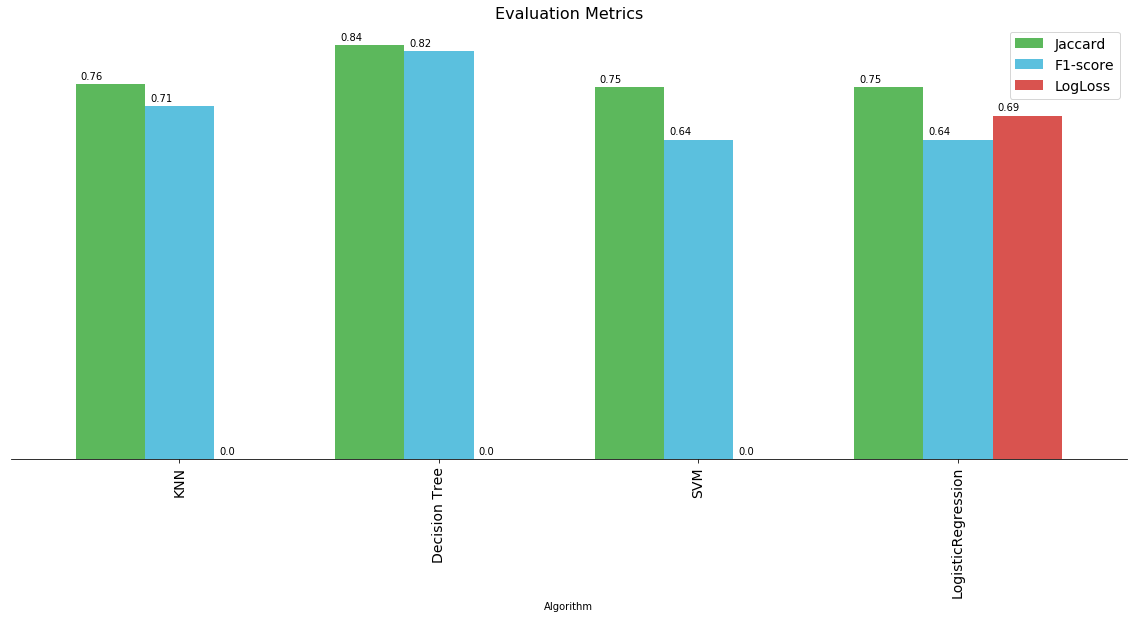

In [111]:
#PLOTTING
ax1 = report_df.plot(kind = 'bar',
                figsize = (20,8),
                width = 0.8,
                color = ('#5cb85c', '#5bc0de', '#d9534f'),
                fontsize = 14)
ax1.set_title("Evaluation Metrics", 
             fontsize = 16)
ax1.legend(fontsize = 14)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)

ax1.axes.get_yaxis().set_ticks([])

# Adding the scores   
for p in ax1.patches:
    ax1.annotate("{:.2}".format(p.get_height()),
                xy=(p.get_x()+0.02, p.get_height()+0.01))
ax1;

### From the Evaluation Metrics its evident that Decision Tree is the best Classifier to use to predict Loan Default for the given Data Set.